In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import numpy as np
import os

os.getcwd()
test_read = np.loadtxt("/content/drive/My Drive/Raw_Data/experiment-i/S1/3.txt")

print(type(test_read))
test_read.shape

<class 'numpy.ndarray'>


(90, 2048)

The dimensions according to the paper are 32 x 64 (which is equal to 2048), meaning that maybe every row of the array is a recording from the mattress. Let's take a look:

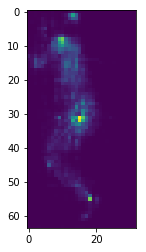

In [3]:
import matplotlib.pyplot as plt

plt.imshow(test_read[6,:].reshape(64,32))

Somehow, the first two recordings are weird in all subjects, so we will ignore them.

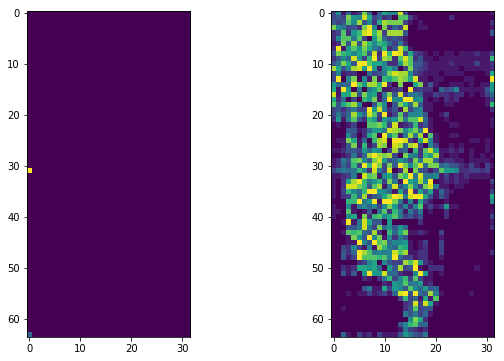

In [4]:

fig, axes = plt.subplots(figsize=(10,6), ncols=2)
for ii in range(2):
    ax = axes[ii]
    ax.imshow(test_read[ii,:].reshape(64,32))


Data Creation

In [0]:
path_exp_1 = "/content/drive/My Drive//Raw_Data/experiment-i/"
positions = ["justAPlaceholder","supine", "right", "left", "right", "right", "left", "left", "supine", "supine", "supine", "supine", "supine", "right", "left", "supine", "supine", "supine"]

data = []
subjects = []
labels = []
files = []

# r=root, d=directories, f = files
for _, d, _ in os.walk(path_exp_1):
    # For each subject
    for directory in d:
        for _, _, f in os.walk(os.path.join(path_exp_1, directory)):            
            # For each position file
            for file in f:
                if '.txt' in file:
                    loaded = np.loadtxt(os.path.join(path_exp_1, directory, file))
                    
                    # First two images are weird.
                    num_images = loaded.shape[0] - 2
                    subj = np.repeat(directory, num_images, axis = 0)
                    subjects.append(subj)
                    
                    #remove file extension
                    position_number = file[:-4]
                    position = positions[int(position_number)]
                    label = np.repeat(position, num_images, axis = 0)
                    labels.append(label)
                    
                    data.append(loaded[2:,:])

In [6]:
# Sanity check:

data_exp_1 = np.vstack(data)
subj_exp_1 = np.hstack(subjects)
labels_exp_1 = np.hstack(labels)

print(f"The number of positions recorded is: {data_exp_1.shape[0]}")
print(f"The number of labels recorded is: {subj_exp_1.shape[0]}")
print(f"The number of subject recordings is: {labels_exp_1.shape[0]}")


The number of positions recorded is: 19582
The number of labels recorded is: 19582
The number of subject recordings is: 19582


In [0]:
from torch.utils.data import Dataset

class MattressExpOne(Dataset):
  def __init__(self):
    self.samples, self.labels = data_exp_1, labels_exp_1
    
  def __len__(self):
    return self.samples.shape[0]
      
  def __getitem__(self, idx):
    return self.samples[idx], self.labels[idx]

PyTorch gives you the freedom to pretty much do anything with the Dataset class so long as you override two of the subclass functions:

+ the __len__ function which returns the size of the dataset, and
+ the __getitem__ function which returns a sample from the dataset given an index.

In [0]:
positions = [
    "justAPlaceholder","supine", "right", "left", "right", "right", 
    "left", "left", "supine", "supine", "supine", "supine", 
    "supine", "right_fetus", "left_fetus", "supine", "supine", "supine"
]

class MattressExpOne(Dataset):
  
  def __init__(self, data_root):
      self.samples = []
      for subject in os.listdir(data_root):
          if subject.startswith("S"):
              subject_folder = os.path.join(data_root, subject)
              for position in os.listdir(subject_folder):
                  position_filepath = os.path.join(subject_folder, position)

                  with open(position_filepath, 'r') as file:
                      # Start from second recording, as the first two are "weird"
                      for line in file.read().splitlines()[2:]:
                          def token_position(x):
                            return {
                                'supine': 0,
                                'left': 1,
                                'right': 2,
                                'left_fetus': 3,
                                'right_fetus': 4
                            }[x]
                          self.samples.append((
                          np.fromstring(line, dtype=float, sep='\t').reshape(64,32),
                          token_position(positions[int(position[:-4])]),
                          subject
                          ))                     
  def __len__(self):
      return len(self.samples)

  def __getitem__(self, idx):
      return self.samples[idx]

In [0]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

data_exp_1 = MattressExpOne("/content/drive/My Drive/Raw_Data/experiment-i/")

trainset_exp_1, valset_exp_1 = random_split(data_exp_1, [round(len(data_exp_1)*0.70), len(data_exp_1) - round(len(data_exp_1)*0.70)])

trainloader = DataLoader(trainset_exp_1, batch_size=64, shuffle=True)
testloader = DataLoader(valset_exp_1, batch_size=64, shuffle=False)

In [20]:
import torch
from torch import nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Input channels = 1, output channels = 6
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(6, 18, kernel_size=3, stride=1, padding=1)
        
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        
        # Inputs to hidden layer linear transformation
        self.h1 = nn.Linear(18 * 16 * 8, 392)
        self.h2 = nn.Linear(392, 98)
        
        # Output layer, 3 neurons - one for each position
        self.output = nn.Linear(98, 5)
        
        # Define sigmoid activation and softmax output 
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = x.float()
        # Add a "channel dimension"
        x = x.unsqueeze(1)
        
        #Computes the activation of the first convolution
        #Size changes from (1, 64, 32) to (6, 64, 32)
        
        x = F.relu(self.conv1(x))

        
        #Size changes from (6, 32, 16) to (6, 32, 16)
        x = self.pool(x)

        
        #Size changes from (6, 32, 16) to (18, 32, 16)
        x = F.relu(self.conv2(x))

        
        #Size changes from (18, 32, 16) to (18, 16, 8)
        x = self.pool(x)
        


        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        
        x = x.view(x.shape[0], -1)
        # Pass the input tensor through each of our operations
        x = self.h1(x)

        x = self.relu(x)
        x = self.h2(x)

        x = self.relu(x)
        x = self.output(x)

        x = self.logsoftmax(x)
        
        return x
      
model = Network()
model

Network(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (h1): Linear(in_features=2304, out_features=392, bias=True)
  (h2): Linear(in_features=392, out_features=98, bias=True)
  (output): Linear(in_features=98, out_features=5, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
from torch import optim

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.01)

model.to(device)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (h1): Linear(in_features=2304, out_features=392, bias=True)
  (h2): Linear(in_features=392, out_features=98, bias=True)
  (output): Linear(in_features=98, out_features=5, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
)

Epoch 1/15.. Train loss: 1.678.. Test loss: 0.049.. Test accuracy: 0.998
Epoch 2/15.. Train loss: 0.024.. Test loss: 0.110.. Test accuracy: 0.995
Epoch 3/15.. Train loss: 0.044.. Test loss: 0.055.. Test accuracy: 0.999
Epoch 4/15.. Train loss: 0.003.. Test loss: 0.088.. Test accuracy: 0.999
Epoch 5/15.. Train loss: 0.112.. Test loss: 0.167.. Test accuracy: 0.997
Epoch 6/15.. Train loss: 0.229.. Test loss: 0.235.. Test accuracy: 0.994
Epoch 7/15.. Train loss: 0.016.. Test loss: 0.184.. Test accuracy: 0.999
Epoch 8/15.. Train loss: 0.003.. Test loss: 0.091.. Test accuracy: 0.998
Epoch 9/15.. Train loss: 0.002.. Test loss: 0.142.. Test accuracy: 0.999
Epoch 10/15.. Train loss: 0.000.. Test loss: 0.142.. Test accuracy: 0.999
Epoch 11/15.. Train loss: 0.000.. Test loss: 0.141.. Test accuracy: 0.999
Epoch 12/15.. Train loss: 0.000.. Test loss: 0.141.. Test accuracy: 0.999
Epoch 13/15.. Train loss: 0.000.. Test loss: 0.141.. Test accuracy: 0.999
Epoch 14/15.. Train loss: 0.000.. Test loss: 0.

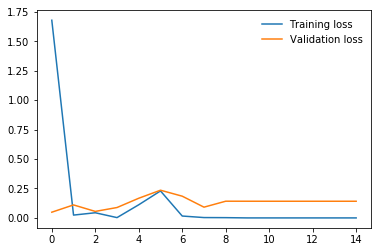

In [23]:
epochs = 15
running_loss = 0

train_losses, test_losses = [], []

for epoch in range(epochs):
  for inputs, labels, _ in trainloader:
  
    inputs, labels = inputs.to(device), labels.to(device)
  
    optimizer.zero_grad()

    logps = model.forward(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  else:
    
    test_loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
      for inputs, labels, _ in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        test_loss += criterion(logps, labels)
        
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
        
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(trainloader):.3f}.. "
          f"Test loss: {test_loss/len(testloader):.3f}.. "
          f"Test accuracy: {accuracy/len(testloader):.3f}")
    running_loss = 0
    model.train()
    
    
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [58]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 64, 32).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(5), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
  
    ax2.set_yticklabels(['supine', 'left', 'right', 'left_fetus', 'right_fetus'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

for inputs, labels, _ in trainloader:
  inputs, labels = inputs.to(device), labels.to(device)
  view_classify(inputs[0].unsqueeze(0).cpu(), torch.exp(model.forward(inputs[0].unsqueeze(0))).cpu())


Output hidden; open in https://colab.research.google.com to view.

In [0]:
from torchvision import transforms

trans = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((70, 32)),
    transforms.ToTensor()
])

myimage = inputs[2].cpu().float()

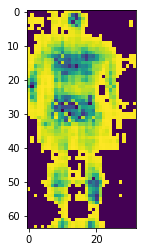

In [128]:
plt.imshow(trans(myimage).view(64,32))

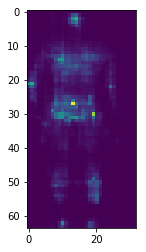

In [131]:
plt.imshow(myimage)

In [122]:
trans(myimage).view(64,32)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9961, 0.9882, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9882,  ..., 0.0000, 0.0000, 0.0000]])

In [123]:
myimage

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [2., 4., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 4.,  ..., 0., 0., 0.]])